# Análise das stacks focais de sedimentoscopia

**Objetivos**
* Levantamento de medidas de avaliação da qualidade de imagens (IQA) de microscopia
* Identificação de posição-ótima do eixo Z para foco em lâminas de sedimentoscopia

# Análise das novas stacks focais

## Posições de foco
### Posições focais identificadas por Mireli Sanrego

<ul> Eixo Z
<li> Focourina1_40x
17.83
<li> Focourina2_40x
18.24
<li> Focourina3_40x
18.14
<li> Focourina4_40x
18.19
<li> Focourina5_40x
18.20
<li> Focourina1_10x
17.86
<li>Focourina2_10x
17.86
</ul>

## Resultados

### Comparativo entre métricas de IQA
#### Comparar resultado e runtime
O tempo de processamento das imagens de cada stack focal variou de 3.71 a 239.34 segundos entre as métricas de IQA. Os três métodos mais rápidos foram o Laplacian (3.71 s), RingDiff (4.93 s), e JpegSize (5.55 s). BRISQUE e FastFourier apresentaram tempos elevados de processamento (72.53 e 73.26 s, respectivamente). E por fim, o método Sharpness teve um tempo 64 vezes superior ao da métrica mais rápida, correndo por 239.34 segundos em média.

### Comparativo entre stacks
#### Distribuição das pontuações nas métricas de IQA
As métricas mostraram resultados satisfatórios e semelhantes em relação a escolha do ponto focal para a maioria das imagens das stacks.<br>
As imagens de sedimentoscopia se apresentam em forma bimodal em relação ao foco. Isso ocorre pois o exame é realizado em meio aquoso translúcido, o que faz aumentar a definição dos artefatos da lamínula. Por isso, os dois pontos focais (lamínula e amostra) são pontuados de maneira semelhante pelas métricas de IQA. <br>
Apesar disso, todas as stacks tiveram pelo menos uma métrica que obtivesse resultado satisfatório, com eleição da própria imagem de foco real na amostra, ou com um desvio de 1 ou 2 imagens para cima ou para baixo do foco real. <br>
Entre as métricas, novamente a métrica com melhor pontuação (menor distância entre imagem eleita e foco real na amostra) foi a JpegSize, com um erro quadrado médio (MSE) de 2.28. Em segundo lugar, a métrica FastFourier obteve resultados satisfatórios, com MSE de 5.57, e em terceiro, o RingDiff, com MSE de 11.28. Todas as demais métricas obtiveram muitos erros, tornando-as desaconselhadas para imagens de sedimentoscopia.

## Discussão 
Nos resultados de runtime, deve ser levado em conta que o tamanho das stacks focais foram maiores do que nos experimentos passados. Em média, foram 200 imagens por stack de 40x. Assim, o valor do runtime reflete o tempo do algoritmo de percorrer todas as 200 imagens e buscar pelo melhor foco. Esse resultado, porém, não reflete o tempo real gasto pelo algoritmo de autofoco durante o exame de microscopia automatizado. <br>
Levando em conta o resultado de distância do ponto real e o tempo de runtime, duas métricas são elegíveis para exames de sedimentoscopia. O método JpegSize obteve os melhores resultados e o terceiro melhor tempo  de processamento. Em seguida, o método RingDiff obteve o terceiro melhor resultado e o segundo melhor tempo de processamento. A método FastFourier apresentou bons resultados, mas um tempo de processamento muito superior que os outros dois métodos.<br>
Em conclusão, esse estudo sugere o uso dos métodos JpegSize e RingDiff para o algoritmo de autofoco em exames de urinálise e sedimentoscopia.




In [3]:
239.34 / 3.71

64.5121293800539

In [1]:
# Iniciamos importando todas as bibliotecas necessárias para rodar as análises
# As medidas de IQA foram definidas em arquivos distintos, sendo necessário também importá-las.

import sys
import os
from sharpness import get_sharpness
from laplacian import variance_of_laplacian
from gabs import ringDiff, jpegSize, fastFourier
from brisque import brisque_score
# from preprocess import preprocess_img
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

# Aqui definimos mais duas funções que serão importantes para avaliação das imagens
# O pré-tratamento é especificamente necessário para essas stacks focais, onde as imagens originais
# contém elementos da janela do navegador

def preprocess_img(image):
    img = cv2.imread(image,1)
    cropped_img = img[102:620, 57:1400]
    return cropped_img

# Aqui definimos a função para cálculo do erro quadrado médio.

def MSE(y_true, y_pred):
    MSE = np.square(np.subtract(y_true,y_pred)).mean()
    return MSE

# BASE_DIR = 'data/'
# stacks240 = os.path.join(BASE_DIR, 'stacks240/')
# stacks160 = os.path.join(BASE_DIR, 'stacks160/')


# Vamos utilizar um diretório base onde se encontrarão os arquivos de imagem das stacks focais.

BASE_DIR = 'data/Stack focal urina/'
stacks40x = os.path.join(BASE_DIR, '40')
stacks10x = os.path.join(BASE_DIR, '10')

# real_focus_dict = {'stack-2': '01560279863809.jpg',
#     'stack-3': '01560279977204.jpg', 'stack-4': '01560280090599.jpg',
#     'stack-5': '01560280206413.jpg', 'stack-7': '01560270248419.jpg',
#     'stack-8': '01560270484974.jpg', 'stack-9': '01560270628081.jpg',
#     'stack-10': '01560270867665.jpg', 'stack-13': '01560271096589.jpg',
#     'stack-14': '01560271168130.jpg', 'stack-16': '01560271326730.jpg',
#     'stack-17': '01560271407288.jpg', 'stack-20': '01560271641218.jpg',
#     'stack-21': '01560271717496.jpg', 'stack-22': '01560271790317.jpg',
#     'stack-23': '01560271870737.jpg', 'stack-24': '01560271949372.jpg',
#     'stack-25': '01560272030405.jpg'}


# Criamos um dicionário para cada uma das medidas de IQA

measurements = dict()
measurements['FastFourier'] = fastFourier
measurements['Laplacian'] = variance_of_laplacian
measurements['RingDiff'] = ringDiff
measurements['JpegSize'] = jpegSize
measurements['Sharpness'] = get_sharpness
measurements['BRISQUE'] = brisque_score

# MEASUREMENT = 'RingDiff'


# Aqui nós importamos os resultados que já foram calculados em uma outra sessão

import pickle

with open('uri_all_stacks_40.pickle', 'rb') as handle:
    all_stacks_40 = pickle.load(handle)

with open('uri_all_stacks_10.pickle', 'rb') as handle:
    all_stacks_10 = pickle.load(handle)

with open('uri_chosen_focuses.pickle', 'rb') as handle:
    chosen_focuses = pickle.load(handle)

### Comparação entre medidas de IQA em relação ao ponto focal

In [5]:
all_stacks_40 = dict()
for folder in os.listdir(stacks40x):
    all_measurements = dict()
    for measurement in measurements.keys():        

        wk_dir = os.path.join(stacks40x, folder)
    #     if folder in real_focus_dict.keys():
    #         real_focus = os.path.join(wk_dir, real_focus_dict[folder])

        img_files = []
        for img_file_name in os.listdir(wk_dir):
            img_file = os.path.join(wk_dir, img_file_name)
            img_files.append(img_file)
        img_files = sorted(img_files)

        res = dict()
        for i in range(len(img_files)):
            res[i] = 0

        print('Running bruteforce algorithm in {} with {} as measurement.'
        .format(folder, measurement))

        count = 0
        zero_percent = True
        twenty_five_percent = True
        fifty_percent = True
        seventy_five_percent = True

        print("Calculating...")
        for img in img_files:
            count += 1
    #             preprocessed_img = preprocess_img(img)

            cropped_img = preprocess_img(img)
            res[count] = measurements[measurement](cropped_img)
            #sorted_dict = {k: v for k, v in sorted(res.items(), key=lambda item: item[1])}
    #         loading = count / len(img_files)

    #         if loading < 0.25 and zero_percent:
    #             print("0%...")
    #             zero_percent = False

    #         elif loading >= 0.25 and twenty_five_percent:
    #             print("25%...")
    #             twenty_five_percent = False

    #         elif loading >= 0.50 and fifty_percent:
    #             print("50%...")
    #             fifty_percent = False

    #         elif loading >= 0.75 and seventy_five_percent:
    #             print("75%...")
    #             seventy_five_percent = False

        #start_position = img_files.index(real_focus)

    #         score2 = sorted_dict[real_focus]

    #         position = list(sorted_dict.keys()).index(real_focus)
    #         print("The correct focus is image {} in {} position, with a score of {}."
    #         .format(real_focus, position, score2))
    #         print("The image is in the {}% percentile of the focal stack".format(
    #             start_position/len(res) * 100
    #         ))
        all_measurements[measurement] = res
    
        all_stacks_40[folder] = all_measurements

Running bruteforce algorithm in Focourina2_40x with FastFourier as measurement.
Calculating...
Running bruteforce algorithm in Focourina2_40x with Laplacian as measurement.
Calculating...
Running bruteforce algorithm in Focourina2_40x with RingDiff as measurement.
Calculating...
Running bruteforce algorithm in Focourina2_40x with JpegSize as measurement.
Calculating...
Running bruteforce algorithm in Focourina2_40x with Sharpness as measurement.
Calculating...
Running bruteforce algorithm in Focourina2_40x with BRISQUE as measurement.
Calculating...
Running bruteforce algorithm in Focourina4_40x with FastFourier as measurement.
Calculating...
Running bruteforce algorithm in Focourina4_40x with Laplacian as measurement.
Calculating...
Running bruteforce algorithm in Focourina4_40x with RingDiff as measurement.
Calculating...
Running bruteforce algorithm in Focourina4_40x with JpegSize as measurement.
Calculating...
Running bruteforce algorithm in Focourina4_40x with Sharpness as measure

In [6]:
all_stacks_10 = dict()
for folder in os.listdir(stacks10x):
    all_measurements = dict()
    print(folder)
    for measurement in measurements.keys():        

        wk_dir = os.path.join(stacks10x, folder)
    #     if folder in real_focus_dict.keys():
    #         real_focus = os.path.join(wk_dir, real_focus_dict[folder])

        img_files = []
        for img_file_name in os.listdir(wk_dir):
            img_file = os.path.join(wk_dir, img_file_name)
            img_files.append(img_file)
        img_files = sorted(img_files)

        res = dict()
        for i in range(len(img_files)):
            res[i] = 0

        print('Running bruteforce algorithm in {} with {} as measurement.'
        .format(folder, measurement))

        count = 0
        zero_percent = True
        twenty_five_percent = True
        fifty_percent = True
        seventy_five_percent = True

        print("Calculating...")
        for img in img_files:
            count += 1
    #             preprocessed_img = preprocess_img(img)

            cropped_img = preprocess_img(img)
            res[count] = measurements[measurement](cropped_img)
            #sorted_dict = {k: v for k, v in sorted(res.items(), key=lambda item: item[1])}
            loading = count / len(img_files)

            if loading < 0.25 and zero_percent:
                print("0%...")
                zero_percent = False

            elif loading >= 0.25 and twenty_five_percent:
                print("25%...")
                twenty_five_percent = False

            elif loading >= 0.50 and fifty_percent:
                print("50%...")
                fifty_percent = False

            elif loading >= 0.75 and seventy_five_percent:
                print("75%...")
                seventy_five_percent = False

        #start_position = img_files.index(real_focus)

    #         score2 = sorted_dict[real_focus]

    #         position = list(sorted_dict.keys()).index(real_focus)
    #         print("The correct focus is image {} in {} position, with a score of {}."
    #         .format(real_focus, position, score2))
    #         print("The image is in the {}% percentile of the focal stack".format(
    #             start_position/len(res) * 100
    #         ))
        all_measurements[measurement] = res
    
        all_stacks_10[folder] = all_measurements

Focourina1_10x
Running bruteforce algorithm in Focourina1_10x with FastFourier as measurement.
Calculating...
0%...
25%...
50%...
75%...
Running bruteforce algorithm in Focourina1_10x with Laplacian as measurement.
Calculating...
0%...
25%...
50%...
75%...
Running bruteforce algorithm in Focourina1_10x with RingDiff as measurement.
Calculating...
0%...
25%...
50%...
75%...
Running bruteforce algorithm in Focourina1_10x with JpegSize as measurement.
Calculating...
0%...
25%...
50%...
75%...
Running bruteforce algorithm in Focourina1_10x with Sharpness as measurement.
Calculating...
0%...
25%...
50%...
75%...
Running bruteforce algorithm in Focourina1_10x with BRISQUE as measurement.
Calculating...
0%...
25%...
50%...
75%...
Focourina2_10x
Running bruteforce algorithm in Focourina2_10x with FastFourier as measurement.
Calculating...
0%...
25%...
50%...
75%...
Running bruteforce algorithm in Focourina2_10x with Laplacian as measurement.
Calculating...
0%...
25%...
50%...
75%...
Running br

In [2]:
all_stacks_40.keys()

dict_keys(['Focourina2_40x_FastFourier', 'Focourina2_40x_Laplacian', 'Focourina2_40x_RingDiff', 'Focourina2_40x_JpegSize', 'Focourina2_40x_Sharpness', 'Focourina2_40x_BRISQUE', 'Focourina4_40x_FastFourier', 'Focourina4_40x_Laplacian', 'Focourina4_40x_RingDiff', 'Focourina4_40x_JpegSize', 'Focourina4_40x_Sharpness', 'Focourina4_40x_BRISQUE', 'Focourina3_40x_FastFourier', 'Focourina3_40x_Laplacian', 'Focourina3_40x_RingDiff', 'Focourina3_40x_JpegSize', 'Focourina3_40x_Sharpness', 'Focourina3_40x_BRISQUE', 'Focourina1_40x_FastFourier', 'Focourina1_40x_Laplacian', 'Focourina1_40x_RingDiff', 'Focourina1_40x_JpegSize', 'Focourina1_40x_Sharpness', 'Focourina1_40x_BRISQUE', 'Focourina5_40x_FastFourier', 'Focourina5_40x_Laplacian', 'Focourina5_40x_RingDiff', 'Focourina5_40x_JpegSize', 'Focourina5_40x_Sharpness', 'Focourina5_40x_BRISQUE'])

<ipython-input-7-d8d9581ffe4b>:4: RuntimeWarning: divide by zero encountered in log
  transform = df_40.applymap(lambda x: np.log(x/10))
<ipython-input-7-d8d9581ffe4b>:4: RuntimeWarning: divide by zero encountered in log
  transform = df_40.applymap(lambda x: np.log(x/10))
<ipython-input-7-d8d9581ffe4b>:4: RuntimeWarning: divide by zero encountered in log
  transform = df_40.applymap(lambda x: np.log(x/10))
<ipython-input-7-d8d9581ffe4b>:4: RuntimeWarning: divide by zero encountered in log
  transform = df_40.applymap(lambda x: np.log(x/10))
<ipython-input-7-d8d9581ffe4b>:4: RuntimeWarning: divide by zero encountered in log
  transform = df_40.applymap(lambda x: np.log(x/10))


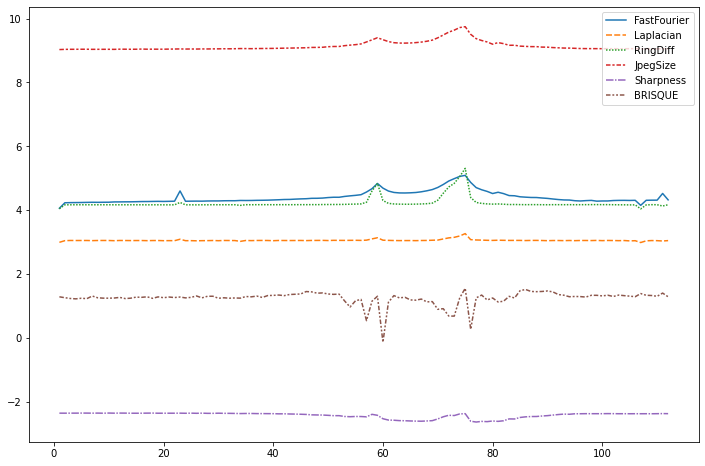

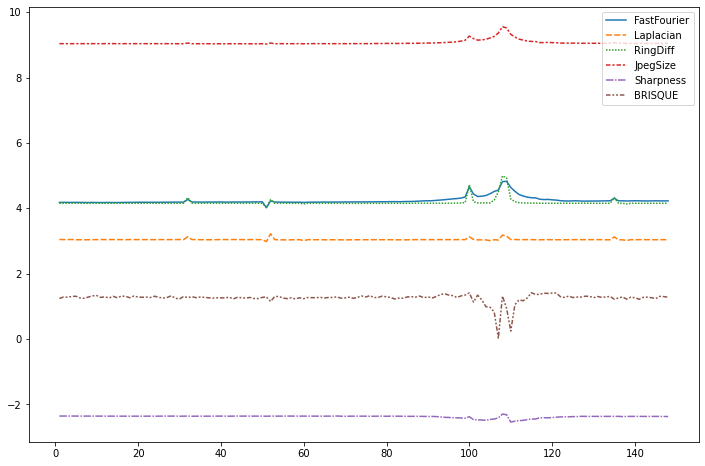

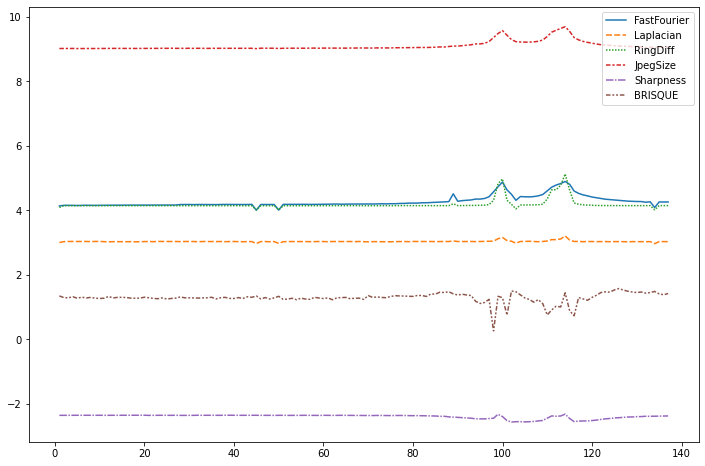

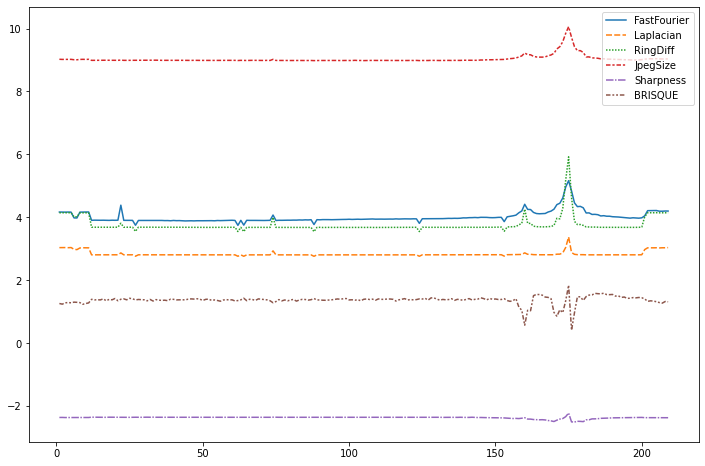

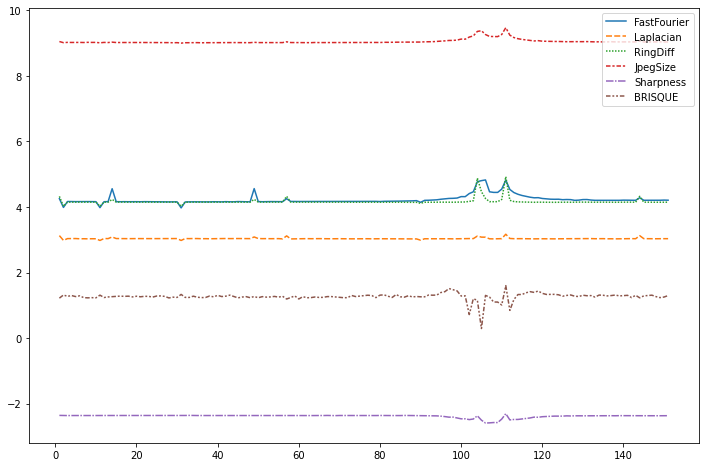

In [7]:
%matplotlib inline
for stack in all_stacks_40.keys():
    df_40 = pd.DataFrame.from_dict(all_stacks_40[stack])
    transform = df_40.applymap(lambda x: np.log(x/10))
    # test.head()
    plt.figure(figsize=(12, 8))
    sns.lineplot(data = transform)
#     plt.savefig('Measurement_Comparison_{}.png'.format(stack))

<ipython-input-8-7a7c183058b1>:4: RuntimeWarning: divide by zero encountered in log
  transform = df_10.applymap(lambda x: np.log(x/10))
<ipython-input-8-7a7c183058b1>:4: RuntimeWarning: divide by zero encountered in log
  transform = df_10.applymap(lambda x: np.log(x/10))


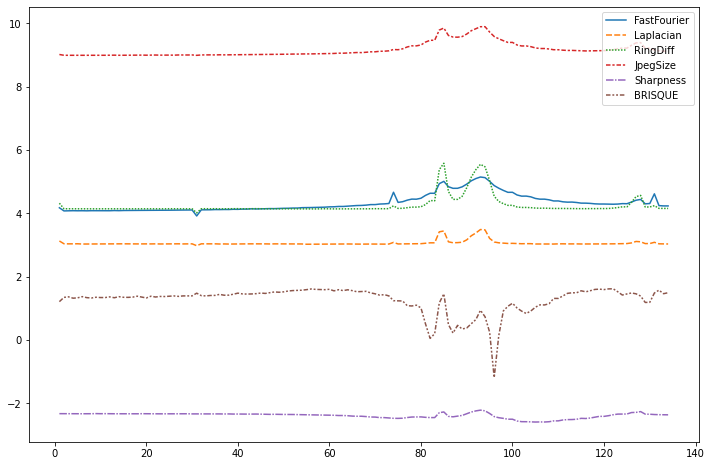

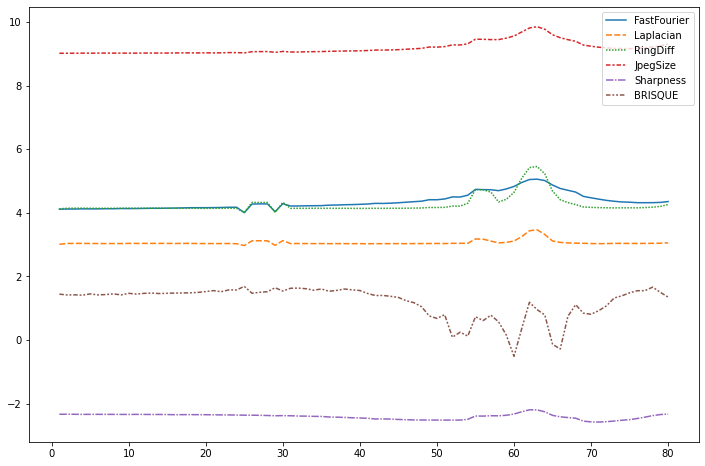

In [8]:
%matplotlib inline
for stack in all_stacks_10.keys():
    df_10 = pd.DataFrame.from_dict(all_stacks_10[stack])
    transform = df_10.applymap(lambda x: np.log(x/10))
    # test.head()
    plt.figure(figsize=(12, 8))
    sns.lineplot(data = transform)
#     plt.savefig('Measurement_Comparison_{}.png'.format(stack))

### Comparação entre os valores ótimos de eixo Z para foco nas imagens de microscopia de sedimentoscopia

In [19]:
z_axes = {}
stacks = [stacks10x, stacks40x]
for stack_folder in stacks:
    for stack in os.listdir(stack_folder):
        with open('data/{}_z_axes.txt'.format(stack), 'r') as f:
            z_list = [z_list_.split(' ') for z_list_ in f][0][:-1]
            z_axes[stack] = z_list
    

In [61]:
MEASUREMENT = 'JpegSize'

In [62]:
all_stacks_40 = dict()
for folder in os.listdir(stacks40x):
    wk_dir = os.path.join(stacks40x, folder)
#     if folder in real_focus_dict.keys():
#         real_focus = os.path.join(wk_dir, real_focus_dict[folder])

    img_files = []
    for img_file_name in os.listdir(wk_dir):
        img_file = os.path.join(wk_dir, img_file_name)
        img_files.append(img_file)
    img_files = sorted(img_files)
    
    res = dict()
#     for i in range(len(img_files)):
#         res[i] = 0

    print('Running bruteforce algorithm in {} with {} as measurement.'
    .format(folder, MEASUREMENT))

    count = 0
    zero_percent = True
    twenty_five_percent = True
    fifty_percent = True
    seventy_five_percent = True

    print("Calculating...")
    for img in img_files:
        count += 1
#             preprocessed_img = preprocess_img(img)

        cropped_img = preprocess_img(img)
        res[count] = measurements[MEASUREMENT](cropped_img)
        #sorted_dict = {k: v for k, v in sorted(res.items(), key=lambda item: item[1])}
        loading = count / len(img_files)

        if loading < 0.25 and zero_percent:
            print("0%...")
            zero_percent = False

        elif loading >= 0.25 and twenty_five_percent:
            print("25%...")
            twenty_five_percent = False

        elif loading >= 0.50 and fifty_percent:
            print("50%...")
            fifty_percent = False

        elif loading >= 0.75 and seventy_five_percent:
            print("75%...")
            seventy_five_percent = False

    #start_position = img_files.index(real_focus)

#         score2 = sorted_dict[real_focus]

#         position = list(sorted_dict.keys()).index(real_focus)
#         print("The correct focus is image {} in {} position, with a score of {}."
#         .format(real_focus, position, score2))
#         print("The image is in the {}% percentile of the focal stack".format(
#             start_position/len(res) * 100
#         ))
    all_stacks_40[folder] = res

Running bruteforce algorithm in Focourina2_40x with JpegSize as measurement.
Calculating...
0%...
25%...
50%...
75%...
Running bruteforce algorithm in Focourina4_40x with JpegSize as measurement.
Calculating...
0%...
25%...
50%...
75%...
Running bruteforce algorithm in Focourina3_40x with JpegSize as measurement.
Calculating...
0%...
25%...
50%...
75%...
Running bruteforce algorithm in Focourina1_40x with JpegSize as measurement.
Calculating...
0%...
25%...
50%...
75%...
Running bruteforce algorithm in Focourina5_40x with JpegSize as measurement.
Calculating...
0%...
25%...
50%...
75%...


In [69]:
df_40 = pd.DataFrame()
first = True
for stack in all_stacks_40.keys():
    stack_num = ['Stack ' + stack.split('_')[0][-1]]
    df_temp = pd.DataFrame.from_dict(all_stacks_40[stack], orient='index')
    df_temp.index = z_axes[stack]
    df_temp.columns = stack_num
    while first:
        df_40.append(df_temp)
        first = False
        break
    df_40 = df_40.merge(df_temp, how='outer', left_index= True, right_index = True)

In [70]:
df_40

Stack 2  Stack 4  Stack 3  Stack 1  Stack 5
16.00      NaN  84035.0      NaN      NaN  85135.0
16.02      NaN      NaN      NaN      NaN  82299.0
16.04      NaN  84060.0      NaN  82860.0  82999.0
16.05      NaN      NaN      NaN  82512.0      NaN
16.06      NaN  83898.0      NaN  82611.0  82790.0
...        ...      ...      ...      ...      ...
18.94      NaN  84914.0      NaN      NaN  84141.0
18.95  85623.0      NaN      NaN      NaN      NaN
18.96      NaN  84791.0      NaN      NaN  84288.0
18.98      NaN  84771.0      NaN      NaN  83977.0
19.00      NaN  84831.0      NaN      NaN  84047.0

[291 rows x 5 columns]

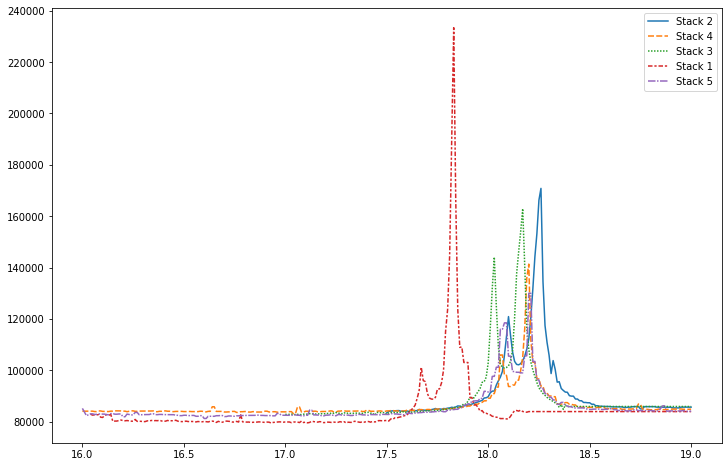

In [153]:
%matplotlib inline
plt.figure(figsize=(12, 8))
fig = sns.lineplot(data=df_40.fillna(method='ffill'))
# plt.show()
plt.savefig('urinalysis_z_value_40x.png')

In [151]:
df_40_x = df_40
df_40_x.index = [float(x) for x in df_40.index]
df_40_x = df_40_x.loc[17.60:18.60]

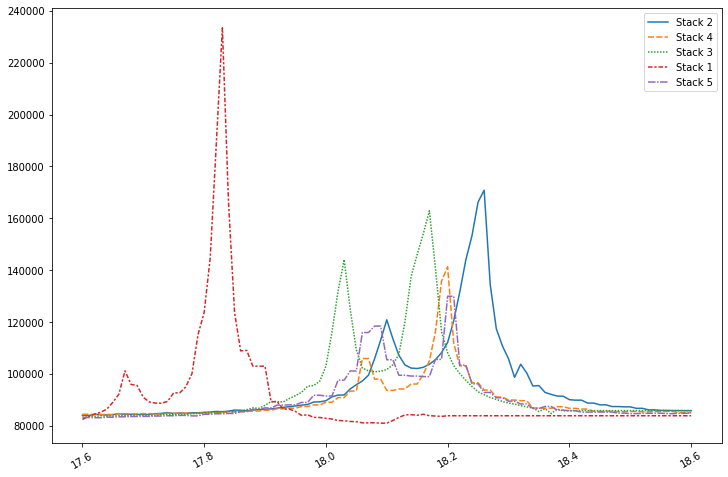

In [154]:
%matplotlib inline
plt.figure(figsize=(12, 8))
x = [float(ind) for ind in df_40_x.index]
max(x)
plt.xticks(rotation=30)
fig = sns.lineplot(data=df_40_x.fillna(method='ffill'))
# plt.show()
plt.savefig('urinalysis_z_value_40x_zoom.png')

In [72]:
all_stacks_10 = dict()
for folder in os.listdir(stacks10x):
    wk_dir = os.path.join(stacks10x, folder)
#     if folder in real_focus_dict.keys():
#         real_focus = os.path.join(wk_dir, real_focus_dict[folder])

    img_files = []
    for img_file_name in os.listdir(wk_dir):
        img_file = os.path.join(wk_dir, img_file_name)
        img_files.append(img_file)
    img_files = sorted(img_files)
    
    res = dict()
#     for i in range(len(img_files)):
#         res[i] = 0

    print('Running bruteforce algorithm in {} with {} as measurement.'
    .format(folder, MEASUREMENT))

    count = 0
    zero_percent = True
    twenty_five_percent = True
    fifty_percent = True
    seventy_five_percent = True

    print("Calculating...")
    for img in img_files:
        count += 1
#             preprocessed_img = preprocess_img(img)

        cropped_img = preprocess_img(img)
        res[count] = measurements[MEASUREMENT](cropped_img)
        #sorted_dict = {k: v for k, v in sorted(res.items(), key=lambda item: item[1])}
        loading = count / len(img_files)

        if loading < 0.25 and zero_percent:
            print("0%...")
            zero_percent = False

        elif loading >= 0.25 and twenty_five_percent:
            print("25%...")
            twenty_five_percent = False

        elif loading >= 0.50 and fifty_percent:
            print("50%...")
            fifty_percent = False

        elif loading >= 0.75 and seventy_five_percent:
            print("75%...")
            seventy_five_percent = False

    #start_position = img_files.index(real_focus)

#         score2 = sorted_dict[real_focus]

#         position = list(sorted_dict.keys()).index(real_focus)
#         print("The correct focus is image {} in {} position, with a score of {}."
#         .format(real_focus, position, score2))
#         print("The image is in the {}% percentile of the focal stack".format(
#             start_position/len(res) * 100
#         ))
    all_stacks_10[folder] = res

Running bruteforce algorithm in Focourina1_10x with JpegSize as measurement.
Calculating...
0%...
25%...
50%...
75%...
Running bruteforce algorithm in Focourina2_10x with JpegSize as measurement.
Calculating...
0%...
25%...
50%...
75%...


In [73]:
df_10 = pd.DataFrame()
first = True
for stack in all_stacks_10.keys():
    stack_num = ['Stack ' + stack.split('_')[0][-1]]
    df_temp = pd.DataFrame.from_dict(all_stacks_10[stack], orient='index')
    df_temp.index = z_axes[stack]
    df_temp.columns = stack_num
    while first:
        df_10.append(df_temp)
        first = False
        break
    df_10 = df_10.merge(df_temp, how='outer', left_index= True, right_index = True)

In [100]:
np.arange(min(x), max(x)+1, 0.2)

array([16. , 16.2, 16.4, 16.6, 16.8, 17. , 17.2, 17.4, 17.6, 17.8, 18. ,
       18.2, 18.4, 18.6, 18.8, 19. , 19.2, 19.4, 19.6])

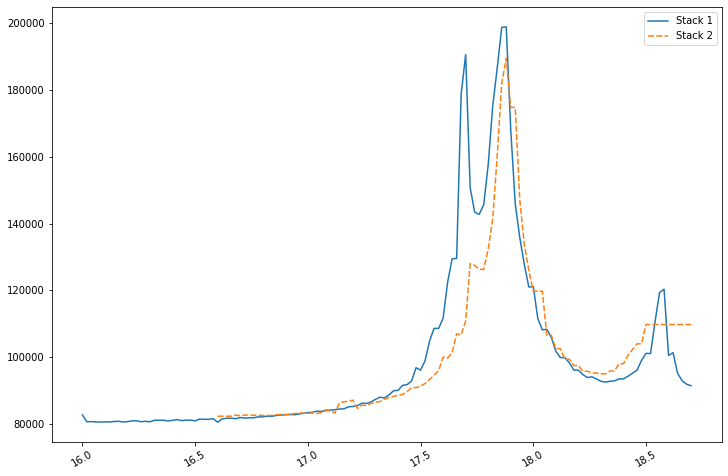

In [155]:
%matplotlib inline
plt.figure(figsize=(12, 8))
x = [float(ind) for ind in df_10.index]
max(x)
plt.xticks(rotation=30)
fig = sns.lineplot(data=df_10.fillna(method='ffill'))
# plt.show()
plt.savefig('urinalysis_z_value_10x.png')

In [118]:
df_10_x = df_10
df_10_x.index = [float(x) for x in df_10.index]
df_10_x = df_10_x.loc[17.40:]

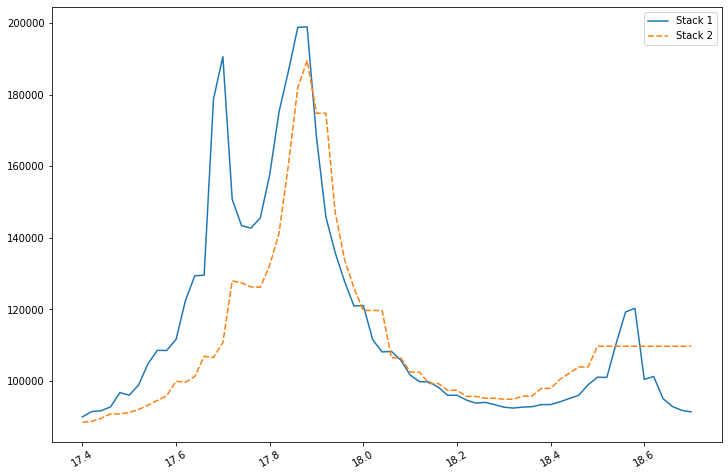

In [156]:
%matplotlib inline
plt.figure(figsize=(12, 8))
x = [float(ind) for ind in df_10_x.index]
max(x)
plt.xticks(rotation=30)
fig = sns.lineplot(data=df_10_x.fillna(method='ffill'))
# plt.show()
plt.savefig('urinalysis_z_value_10x_zoom.png')

### Avaliando os métodos de IQA em relação as imagens elegidas como melhor foco.
#### Comparando os runtimes de cada método.

In [157]:
########### Showing chosen images
chosen_focuses = dict()
all_stacks_40 = dict()
runtimes = dict()
for folder in os.listdir(stacks40x):
    wk_dir = os.path.join(stacks40x, folder)

    img_files = []
    for img_file_name in os.listdir(wk_dir):
        img_file = os.path.join(wk_dir, img_file_name)
        img_files.append(img_file)
    img_files = sorted(img_files)
    
    res = dict()

    for MEASUREMENT in measurements.keys():
        print("Measuring {} with {}".format(folder, MEASUREMENT))
        start_time = time.time()
        count = 0
        for img in img_files:
            count += 1

            
            cropped_img = preprocess_img(img)
            
            res[img] = measurements[MEASUREMENT](cropped_img)
        chosen_focus = max(res, key=res.get)
            
#             res[count] = measurements[MEASUREMENT](cropped_img)

#         chosen_focus = img_files[max(res, key=res.get)]

        key = "{}_{}".format(folder, MEASUREMENT)
        chosen_focuses[key] = chosen_focus
        
        all_stacks_40[key] = res
        end_time = time.time()
        
        runtime = end_time - start_time
        
        runtimes[key] = runtime
        
        print("Found the best focused image. \n Total runtime: {}".format(runtime))
    
all_stacks_10 = dict()
for folder in os.listdir(stacks10x):
    wk_dir = os.path.join(stacks10x, folder)

    img_files = []
    for img_file_name in os.listdir(wk_dir):
        img_file = os.path.join(wk_dir, img_file_name)
        img_files.append(img_file)
    img_files = sorted(img_files)
    
    res = dict()

    for MEASUREMENT in measurements.keys():
        print("Measuring {} with {}".format(folder, MEASUREMENT))
        start_time = time.time()
        count = 0
        for img in img_files:
            count += 1
            cropped_img = preprocess_img(img)
            
            res[img] = measurements[MEASUREMENT](cropped_img)
        chosen_focus = max(res, key=res.get)
            
#             res[count] = measurements[MEASUREMENT](cropped_img)

#         chosen_focus = img_files[max(res, key=res.get)]
        
        key = "{}_{}".format(folder, MEASUREMENT)
        chosen_focuses[key] = chosen_focus
        all_stacks_10[key] = res
        
        end_time = time.time()
        
        runtime = end_time - start_time
        
        runtimes[key] = runtime
        
        print("Found the best focused image. \n Total runtime: {}".format(runtime))

Measuring Focourina2_40x with FastFourier
Found the best focused image. 
 Total runtime: 59.34226059913635
Measuring Focourina2_40x with Laplacian
Found the best focused image. 
 Total runtime: 3.926907777786255
Measuring Focourina2_40x with RingDiff
Found the best focused image. 
 Total runtime: 6.320791244506836
Measuring Focourina2_40x with JpegSize
Found the best focused image. 
 Total runtime: 8.352350234985352
Measuring Focourina2_40x with Sharpness
Found the best focused image. 
 Total runtime: 194.4225001335144
Measuring Focourina2_40x with BRISQUE
Found the best focused image. 
 Total runtime: 49.93098163604736
Measuring Focourina4_40x with FastFourier
Found the best focused image. 
 Total runtime: 70.864004611969
Measuring Focourina4_40x with Laplacian
Found the best focused image. 
 Total runtime: 3.3681838512420654
Measuring Focourina4_40x with RingDiff
Found the best focused image. 
 Total runtime: 4.057445049285889
Measuring Focourina4_40x with JpegSize
Found the best foc

In [160]:
import pickle
with open('uri_all_stacks_40.pickle', 'wb') as handle:
    pickle.dump(all_stacks_40, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('uri_all_stacks_10.pickle', 'wb') as handle:
    pickle.dump(all_stacks_10, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('uri_chosen_focuses.pickle', 'wb') as handle:
    pickle.dump(chosen_focuses, handle, protocol=pickle.HIGHEST_PROTOCOL)

Showing chosen images for Focourina110x


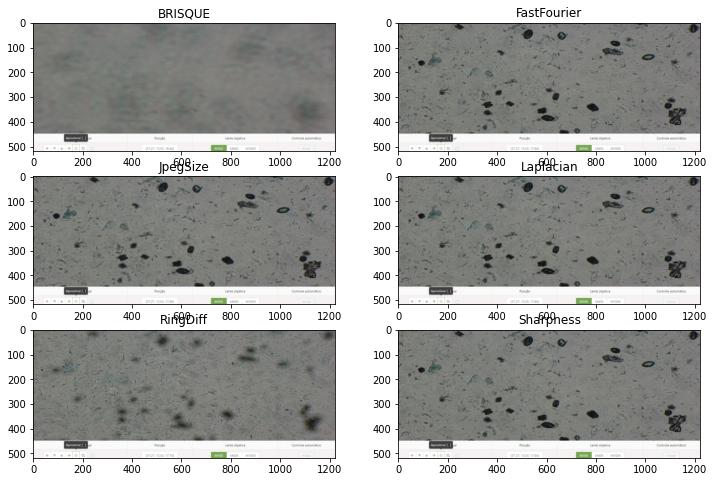

Showing chosen images for Focourina140x


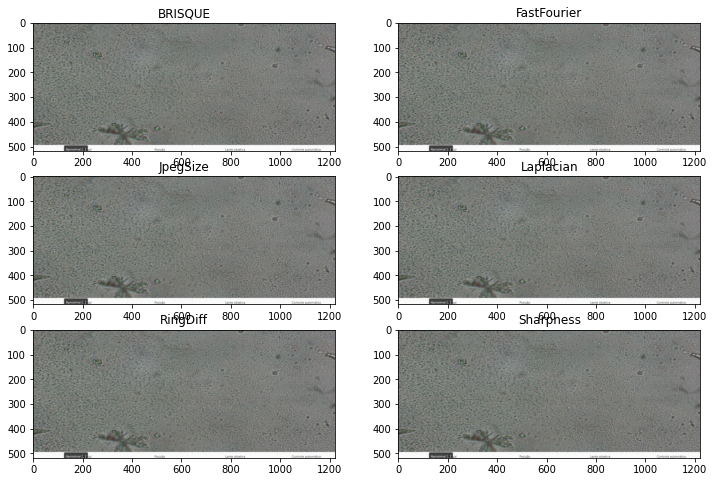

Showing chosen images for Focourina210x


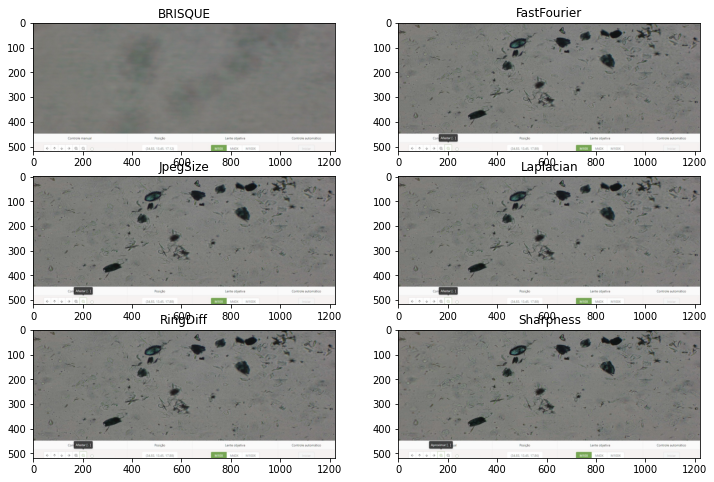

Showing chosen images for Focourina240x


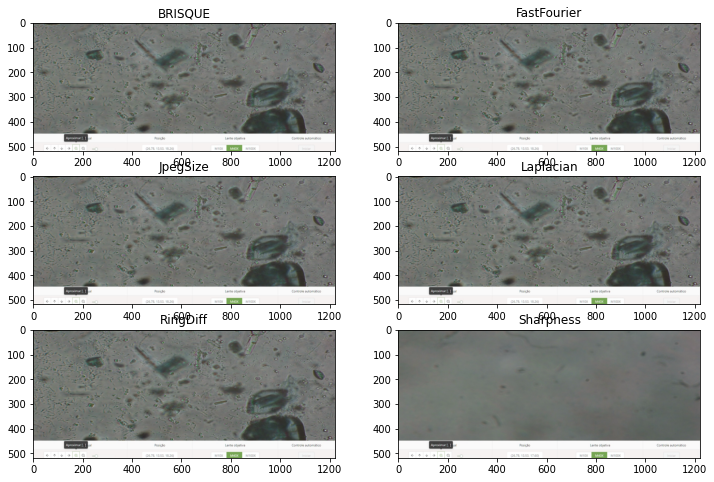

Showing chosen images for Focourina340x


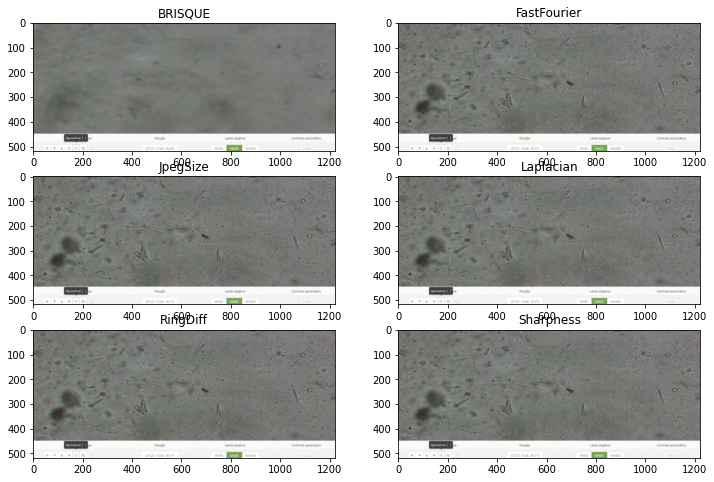

Showing chosen images for Focourina440x


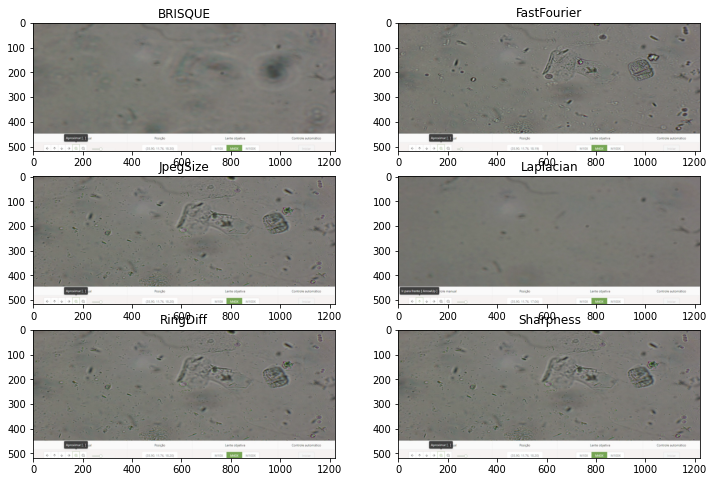

Showing chosen images for Focourina540x


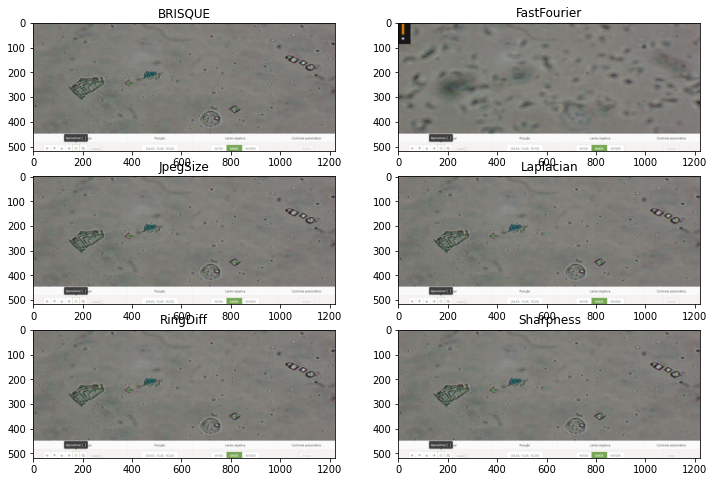

IndexError: list index out of range

In [165]:
sorted_chosen_focuses = sorted(chosen_focuses)

for i in range(0, 48, 6):
    stack_name = ''.join(sorted_chosen_focuses[i].split("_")[:-1])
    print("Showing chosen images for {}".format(stack_name))
    
    i1 = preprocess_img(chosen_focuses[sorted_chosen_focuses[i]])
    i2 = preprocess_img(chosen_focuses[sorted_chosen_focuses[i+1]])
    i3 = preprocess_img(chosen_focuses[sorted_chosen_focuses[i+2]])
    i4 = preprocess_img(chosen_focuses[sorted_chosen_focuses[i+3]])
    i5 = preprocess_img(chosen_focuses[sorted_chosen_focuses[i+4]])
    i6 = preprocess_img(chosen_focuses[sorted_chosen_focuses[i+5]])   

    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 8))

    ax1.imshow(i1)
    ax1.set_title(str(sorted_chosen_focuses[i].split("_")[-1]))
    ax2.imshow(i2)
    ax2.set_title(str(sorted_chosen_focuses[i+1].split("_")[-1]))
    ax3.imshow(i3)
    ax3.set_title(str(sorted_chosen_focuses[i+2].split("_")[-1]))
    ax4.imshow(i4)
    ax4.set_title(str(sorted_chosen_focuses[i+3].split("_")[-1]))
    ax5.imshow(i5)
    ax5.set_title(str(sorted_chosen_focuses[i+4].split("_")[-1]))
    ax6.imshow(i6)
    ax6.set_title(str(sorted_chosen_focuses[i+5].split("_")[-1]))
    
    plt.savefig("Chosen Images for {}".format(stack_name))
    plt.show()

In [164]:
for i in range(0, 48, 6):
    stack_name = ''.join(sorted_chosen_focuses[i].split("_")[:-1])
    print("Showing chosen images names for {}".format(stack_name))
    
    i1 = chosen_focuses[sorted_chosen_focuses[i]]
    i2 = chosen_focuses[sorted_chosen_focuses[i+1]]
    i3 = chosen_focuses[sorted_chosen_focuses[i+2]]
    i4 = chosen_focuses[sorted_chosen_focuses[i+3]]
    i5 = chosen_focuses[sorted_chosen_focuses[i+4]]
    i6 = chosen_focuses[sorted_chosen_focuses[i+5]]
    
    print(i1)
    print(i2)
    print(i3)
    print(i4)
    print(i5)
    print(i6)

Showing chosen images names for Focourina110x
data/Stack focal urina/10/Focourina1_10x/WhatsApp Image 2020-09-30 at 16.46.23.jpeg
data/Stack focal urina/10/Focourina1_10x/WhatsApp Image 2020-09-30 at 16.42.37.jpeg
data/Stack focal urina/10/Focourina1_10x/WhatsApp Image 2020-09-30 at 16.42.47.jpeg
data/Stack focal urina/10/Focourina1_10x/WhatsApp Image 2020-09-30 at 16.42.37.jpeg
data/Stack focal urina/10/Focourina1_10x/WhatsApp Image 2020-09-30 at 16.41.20.jpeg
data/Stack focal urina/10/Focourina1_10x/WhatsApp Image 2020-09-30 at 16.42.37.jpeg
Showing chosen images names for Focourina140x
data/Stack focal urina/40/Focourina1_40x/WhatsApp Image 2020-09-24 at 18.22.31.jpeg
data/Stack focal urina/40/Focourina1_40x/WhatsApp Image 2020-09-24 at 18.22.31.jpeg
data/Stack focal urina/40/Focourina1_40x/WhatsApp Image 2020-09-24 at 18.22.31.jpeg
data/Stack focal urina/40/Focourina1_40x/WhatsApp Image 2020-09-24 at 18.22.31.jpeg
data/Stack focal urina/40/Focourina1_40x/WhatsApp Image 2020-09-24 a

IndexError: list index out of range

In [167]:
#### Runtimes
runtimes_brisque = dict()
runtimes_sharpness = dict()
runtimes_jpegsize = dict()
runtimes_ringdiff = dict()
runtimes_laplacian = dict()
runtimes_fastfourier = dict()

for key in runtimes.keys():
    stack = ''.join(key.split("_")[:-1])
    measurement = ''.join(key.split("_")[-1])
    
    if measurement == "BRISQUE":
        runtimes_brisque[stack] = runtimes[key]
    
    elif measurement == "Sharpness":
        runtimes_sharpness[stack] = runtimes[key]
        
#         runtimes_sharpness.append(df)

    elif measurement == "Laplacian":
        runtimes_laplacian[stack] = runtimes[key]
        
    elif measurement == "FastFourier":
        runtimes_fastfourier[stack] = runtimes[key]
        
    elif measurement == "JpegSize":
        runtimes_jpegsize[stack] = runtimes[key]
                
    elif measurement == "RingDiff":
        runtimes_ringdiff[stack] = runtimes[key]

        
runtimes_laplacian = pd.DataFrame.from_dict(runtimes_laplacian, orient = 'index')
runtimes_fastfourier = pd.DataFrame.from_dict(runtimes_fastfourier, orient = "index")
runtimes_jpegsize = pd.DataFrame.from_dict(runtimes_jpegsize, orient = "index")
runtimes_ringdiff = pd.DataFrame.from_dict(runtimes_ringdiff, orient = "index")
runtimes_sharpness = pd.DataFrame.from_dict(runtimes_sharpness, orient = "index")

runtimes_df = pd.DataFrame.from_dict(runtimes_brisque, orient = "index")

runtimes_df = runtimes_df.merge(runtimes_sharpness, how = "outer", left_index = True,
                                    right_index = True)
runtimes_df = runtimes_df.merge(runtimes_laplacian, how = "outer", left_index = True,
                               right_index = True)
runtimes_df = runtimes_df.merge(runtimes_fastfourier, how = "outer", left_index = True,
                               right_index = True)
runtimes_df = runtimes_df.merge(runtimes_jpegsize, how = "outer", left_index = True,
                               right_index = True)
runtimes_df = runtimes_df.merge(runtimes_ringdiff, how = "outer", left_index = True,
                               right_index = True)
runtimes_df.columns = [
    "BRISQUE", "Sharpness", "Laplacian", "FastFourier", "JpegSize", "RingDiff"
]

runtimes_df.sort_values("JpegSize", inplace=True)

In [168]:
runtimes_df

BRISQUE   Sharpness  Laplacian  FastFourier  JpegSize  \
Focourina110x   84.794225  190.182711   3.132570    62.103938  4.026205   
Focourina540x   67.589084  210.884963   3.544787    68.044075  4.412148   
Focourina210x   43.072994  210.199481   3.216683    60.986863  4.476115   
Focourina440x   83.093779  220.715900   3.368184    70.864005  4.711566   
Focourina340x   67.150314  262.844758   3.623384    84.751805  5.944318   
Focourina140x  112.092674  386.165056   5.192952   106.757366  6.925477   
Focourina240x   49.930982  194.422500   3.926908    59.342261  8.352350   

               RingDiff  
Focourina110x  3.820462  
Focourina540x  4.152929  
Focourina210x  4.071738  
Focourina440x  4.057445  
Focourina340x  5.692669  
Focourina140x  6.389606  
Focourina240x  6.320791

In [169]:
runtimes_df.mean()

BRISQUE         72.532007
Sharpness      239.345053
Laplacian        3.715067
FastFourier     73.264330
JpegSize         5.549740
RingDiff         4.929377
dtype: float64

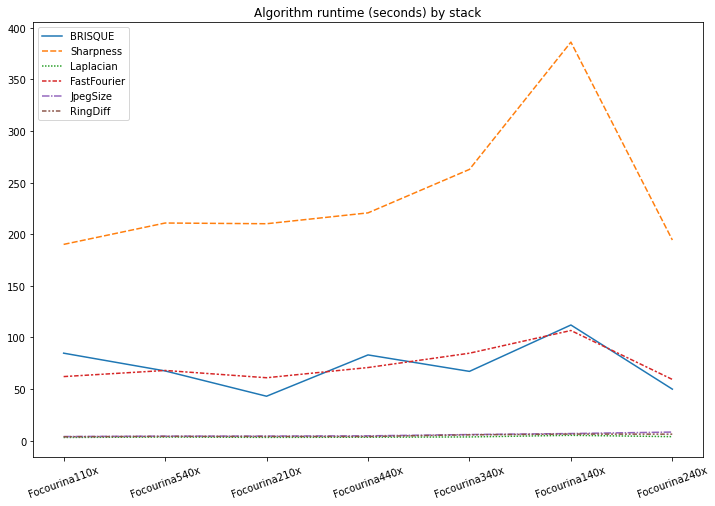

In [170]:
%matplotlib inline
plt.figure(figsize=(12, 8))
fig = sns.lineplot(data=runtimes_df)
# plt.show()
plt.title("Algorithm runtime (seconds) by stack")
plt.xticks(rotation=20)
plt.savefig('uri_runtimes_by_measurement.png')

In [ ]:
z_axes = [float(z) for z in z_axes]

In [ ]:
df_40 = pd.DataFrame()
first = True
for stack in all_stacks_40.keys():
    stack_num = ['Stack ' + stack.split('_')[0][-1]]
    df_temp = pd.DataFrame.from_dict(all_stacks_40[stack], orient='index')
    df_temp.index = z_axes[stack]
    df_temp.columns = stack_num
    while first:
        df_40.append(df_temp)
        first = False
        break
    df_40 = df_40.merge(df_temp, how='outer', left_index= True, right_index = True)

In [197]:
real_focus = {}
stacks = [
    "Focourina1_40x",
    "Focourina2_40x",
    "Focourina3_40x",
    "Focourina4_40x",
    "Focourina5_40x",
    "Focourina1_10x",
    "Focourina2_10x"
]
real_focuses = [
    "WhatsApp Image 2020-09-24 at 18.22.31.jpeg",
    "WhatsApp Image 2020-09-24 at 19.02.44.jpeg",
    "WhatsApp Image 2020-09-30 at 17.16.33.jpeg",
    "WhatsApp Image 2020-09-23 at 17.19.09.jpeg",
    "WhatsApp Image 2020-09-23 at 16.28.29.jpeg",
    "WhatsApp Image 2020-09-30 at 16.42.37.jpeg",
    "WhatsApp Image 2020-09-30 at 17.59.47.jpeg"
]

for i in stacks:
    real_focus[i] = real_focuses[stacks.index(i)]

In [198]:
real_focus

{'Focourina1_40x': 'WhatsApp Image 2020-09-24 at 18.22.31.jpeg',
 'Focourina2_40x': 'WhatsApp Image 2020-09-24 at 19.02.44.jpeg',
 'Focourina3_40x': 'WhatsApp Image 2020-09-30 at 17.16.33.jpeg',
 'Focourina4_40x': 'WhatsApp Image 2020-09-23 at 17.19.09.jpeg',
 'Focourina5_40x': 'WhatsApp Image 2020-09-23 at 16.28.29.jpeg',
 'Focourina1_10x': 'WhatsApp Image 2020-09-30 at 16.42.37.jpeg',
 'Focourina2_10x': 'WhatsApp Image 2020-09-30 at 17.59.47.jpeg'}

In [191]:
for folder in os.listdir(stacks10x):
    print(folder)

Focourina1_10x
Focourina2_10x


In [199]:
aff = dict()

for folder in os.listdir(stacks10x):
    wk_dir = os.path.join(stacks10x, folder)

    img_files = []
    for img_file_name in os.listdir(wk_dir):
        img_file = os.path.join(wk_dir, img_file_name)
        img_files.append(img_file)
    img_files = sorted(img_files)  
#     print(img_files)
    manual_focus = real_focus[folder]
    fp_focus = os.path.join(wk_dir, manual_focus)
    
    focus_idx = img_files.index(fp_focus)
    
    for key in chosen_focuses:
        if folder in key:
            chosen_focus = chosen_focuses[key]
#             print(chosen_focus)
            chosen_focus_idx = img_files.index(chosen_focus)
    
#             print(chosen_focus_idx)

            aff_point = chosen_focus_idx - focus_idx
    
            aff[key] = aff_point
        
for folder in os.listdir(stacks40x):
    wk_dir = os.path.join(stacks40x, folder)

    img_files = []
    for img_file_name in os.listdir(wk_dir):
        img_file = os.path.join(wk_dir, img_file_name)
        img_files.append(img_file)
    img_files = sorted(img_files)  
#     print(img_files)
    manual_focus = real_focus[folder]
    fp_focus = os.path.join(wk_dir, manual_focus)
    
    focus_idx = img_files.index(fp_focus)
    
    for key in chosen_focuses:
        if folder in key:
            chosen_focus = chosen_focuses[key]
#             print(chosen_focus)
            chosen_focus_idx = img_files.index(chosen_focus)
    
#             print(chosen_focus_idx)

            aff_point = chosen_focus_idx - focus_idx
    
            aff[key] = aff_point

In [200]:
stack_list = []
for key in aff:
    stack = ''.join(key.split("_")[:-1])
    stack_list.append(stack)

aff_df_dict = dict()

for i in stack_list:
    aff_df_dict[i] = 0

aff_df = pd.DataFrame.from_dict(aff_df_dict, orient="index")

for measurement in measurements:
    aff_points = dict()
    for key in aff:
        if measurement in key:
            stack = ''.join(key.split("_")[:-1])
            aff_points[stack] = aff[key]
            
    temp_df = pd.DataFrame.from_dict(aff_points, orient = "index")
    temp_df.columns = [measurement]
    
    aff_df = aff_df.merge(temp_df, how = "outer", left_index = True, right_index = True)
aff_df.drop(0, axis = 1, inplace=True)

In [201]:
aff_df.sort_values("Laplacian", inplace=True)
aff_df

FastFourier  Laplacian  RingDiff  JpegSize  Sharpness  BRISQUE
Focourina440x            0        -57        -1        -1         -1        6
Focourina110x            0          0        -8         1          0       29
Focourina140x            0          0         0         0          0        0
Focourina540x           -5          0         0         0          0        0
Focourina210x            1          1         1         1          0      -37
Focourina240x            2          2         2         2        -63        2
Focourina340x            3          3         3         3          3       15

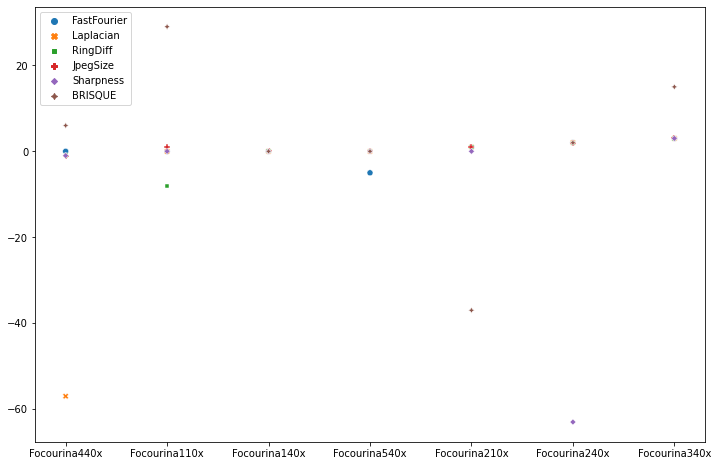

In [202]:
%matplotlib inline
plt.figure(figsize=(12, 8))
fig = sns.scatterplot(data=aff_df)
# plt.show()
# plt.savefig('away_from_focus.png')

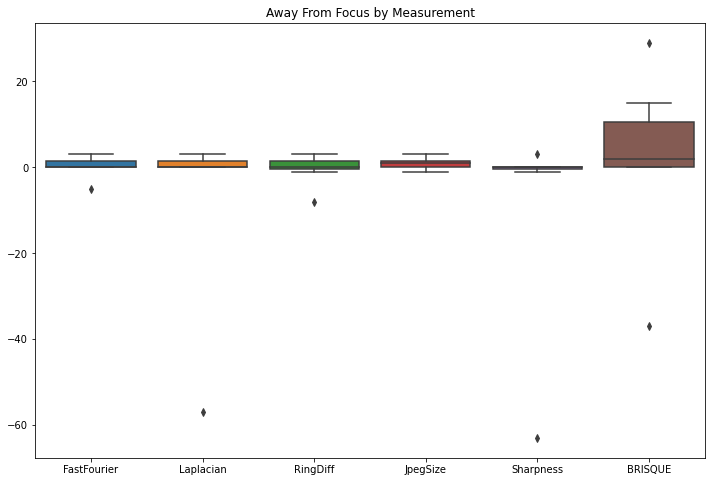

In [203]:
%matplotlib inline
plt.figure(figsize=(12, 8))
fig = sns.boxplot(data=aff_df)
plt.title("Away From Focus by Measurement")
# plt.show()
plt.savefig('uri_away_from_focus_boxplot.png')

In [205]:
y_true = [0, 0, 0, 0, 0, 0, 0]

for measurement in aff_df.columns:
    y_pred = []
    for stack in aff_df[measurement]:
        y_pred.append(stack)
    
    print("{} has a MSE of {}".format(measurement, MSE(y_true, y_pred)))

FastFourier has a MSE of 5.571428571428571
Laplacian has a MSE of 466.14285714285717
RingDiff has a MSE of 11.285714285714286
JpegSize has a MSE of 2.2857142857142856
Sharpness has a MSE of 568.4285714285714
BRISQUE has a MSE of 353.57142857142856
